# Predicting Life Expectancy with AWS SageMaker Linear learner and XG-Boost Regression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sagemaker
import boto3
import io
import sagemaker.amazon.common as smac
import os
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [5]:
data = pd.read_csv('Life_Expectancy_Data.csv')

In [6]:
data.head(5)

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## data analysis EDA:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             2938 non-null   int64  
 1   Status                           2938 non-null   object 
 2   Life expectancy                  2928 non-null   float64
 3   Adult Mortality                  2928 non-null   float64
 4   infant deaths                    2938 non-null   int64  
 5   Alcohol                          2744 non-null   float64
 6   percentage expenditure           2938 non-null   float64
 7   Hepatitis B                      2385 non-null   float64
 8   Measles                          2938 non-null   int64  
 9    BMI                             2904 non-null   float64
 10  under-five deaths                2938 non-null   int64  
 11  Polio                            2919 non-null   float64
 12  Total expenditure   

In [8]:
data.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


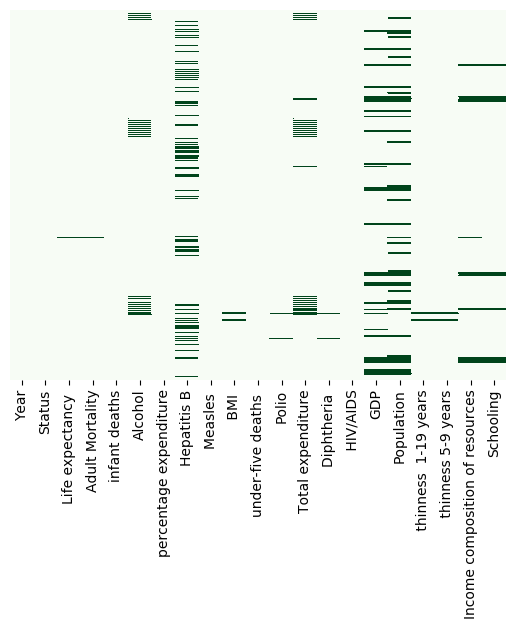

In [9]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap="Greens")
plt.show()

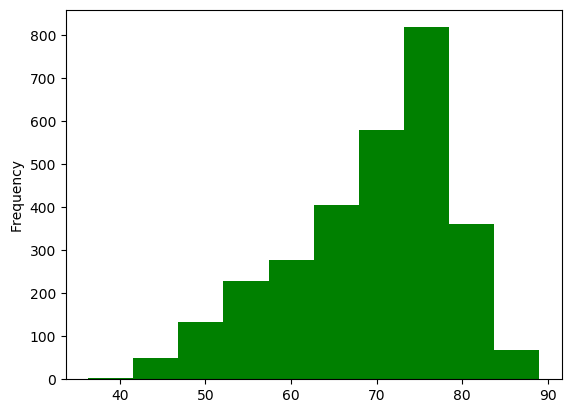

In [10]:
data['Life expectancy '].plot(kind='hist', color='g')
plt.show()

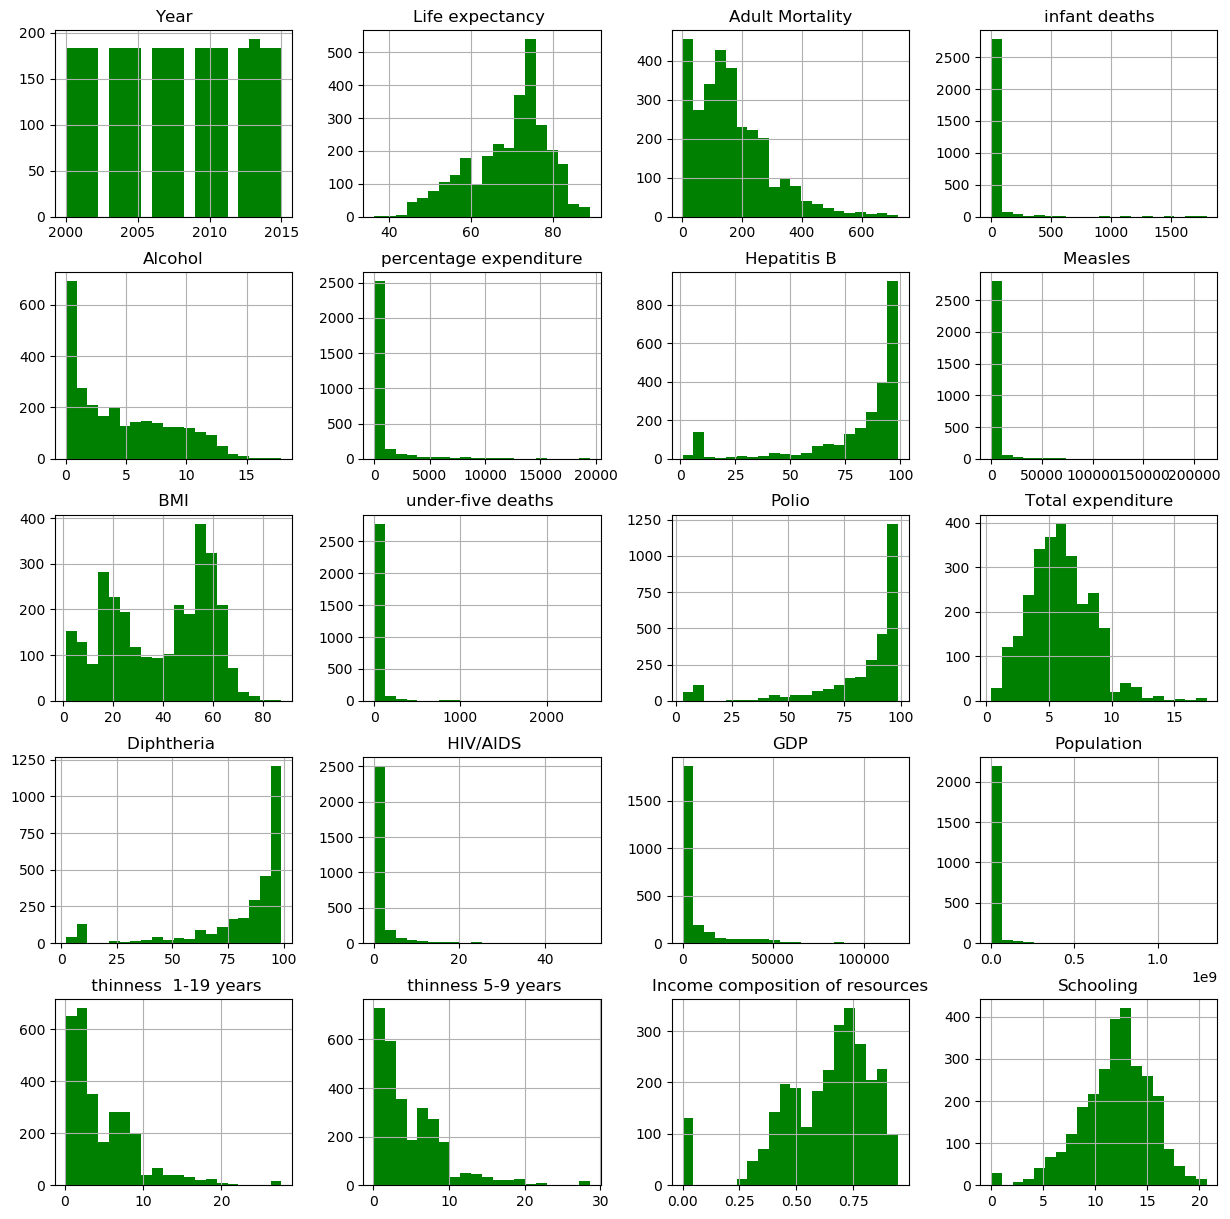

In [11]:
data.hist(bins = 20, figsize = (15, 15), color = 'g');
plt.show()

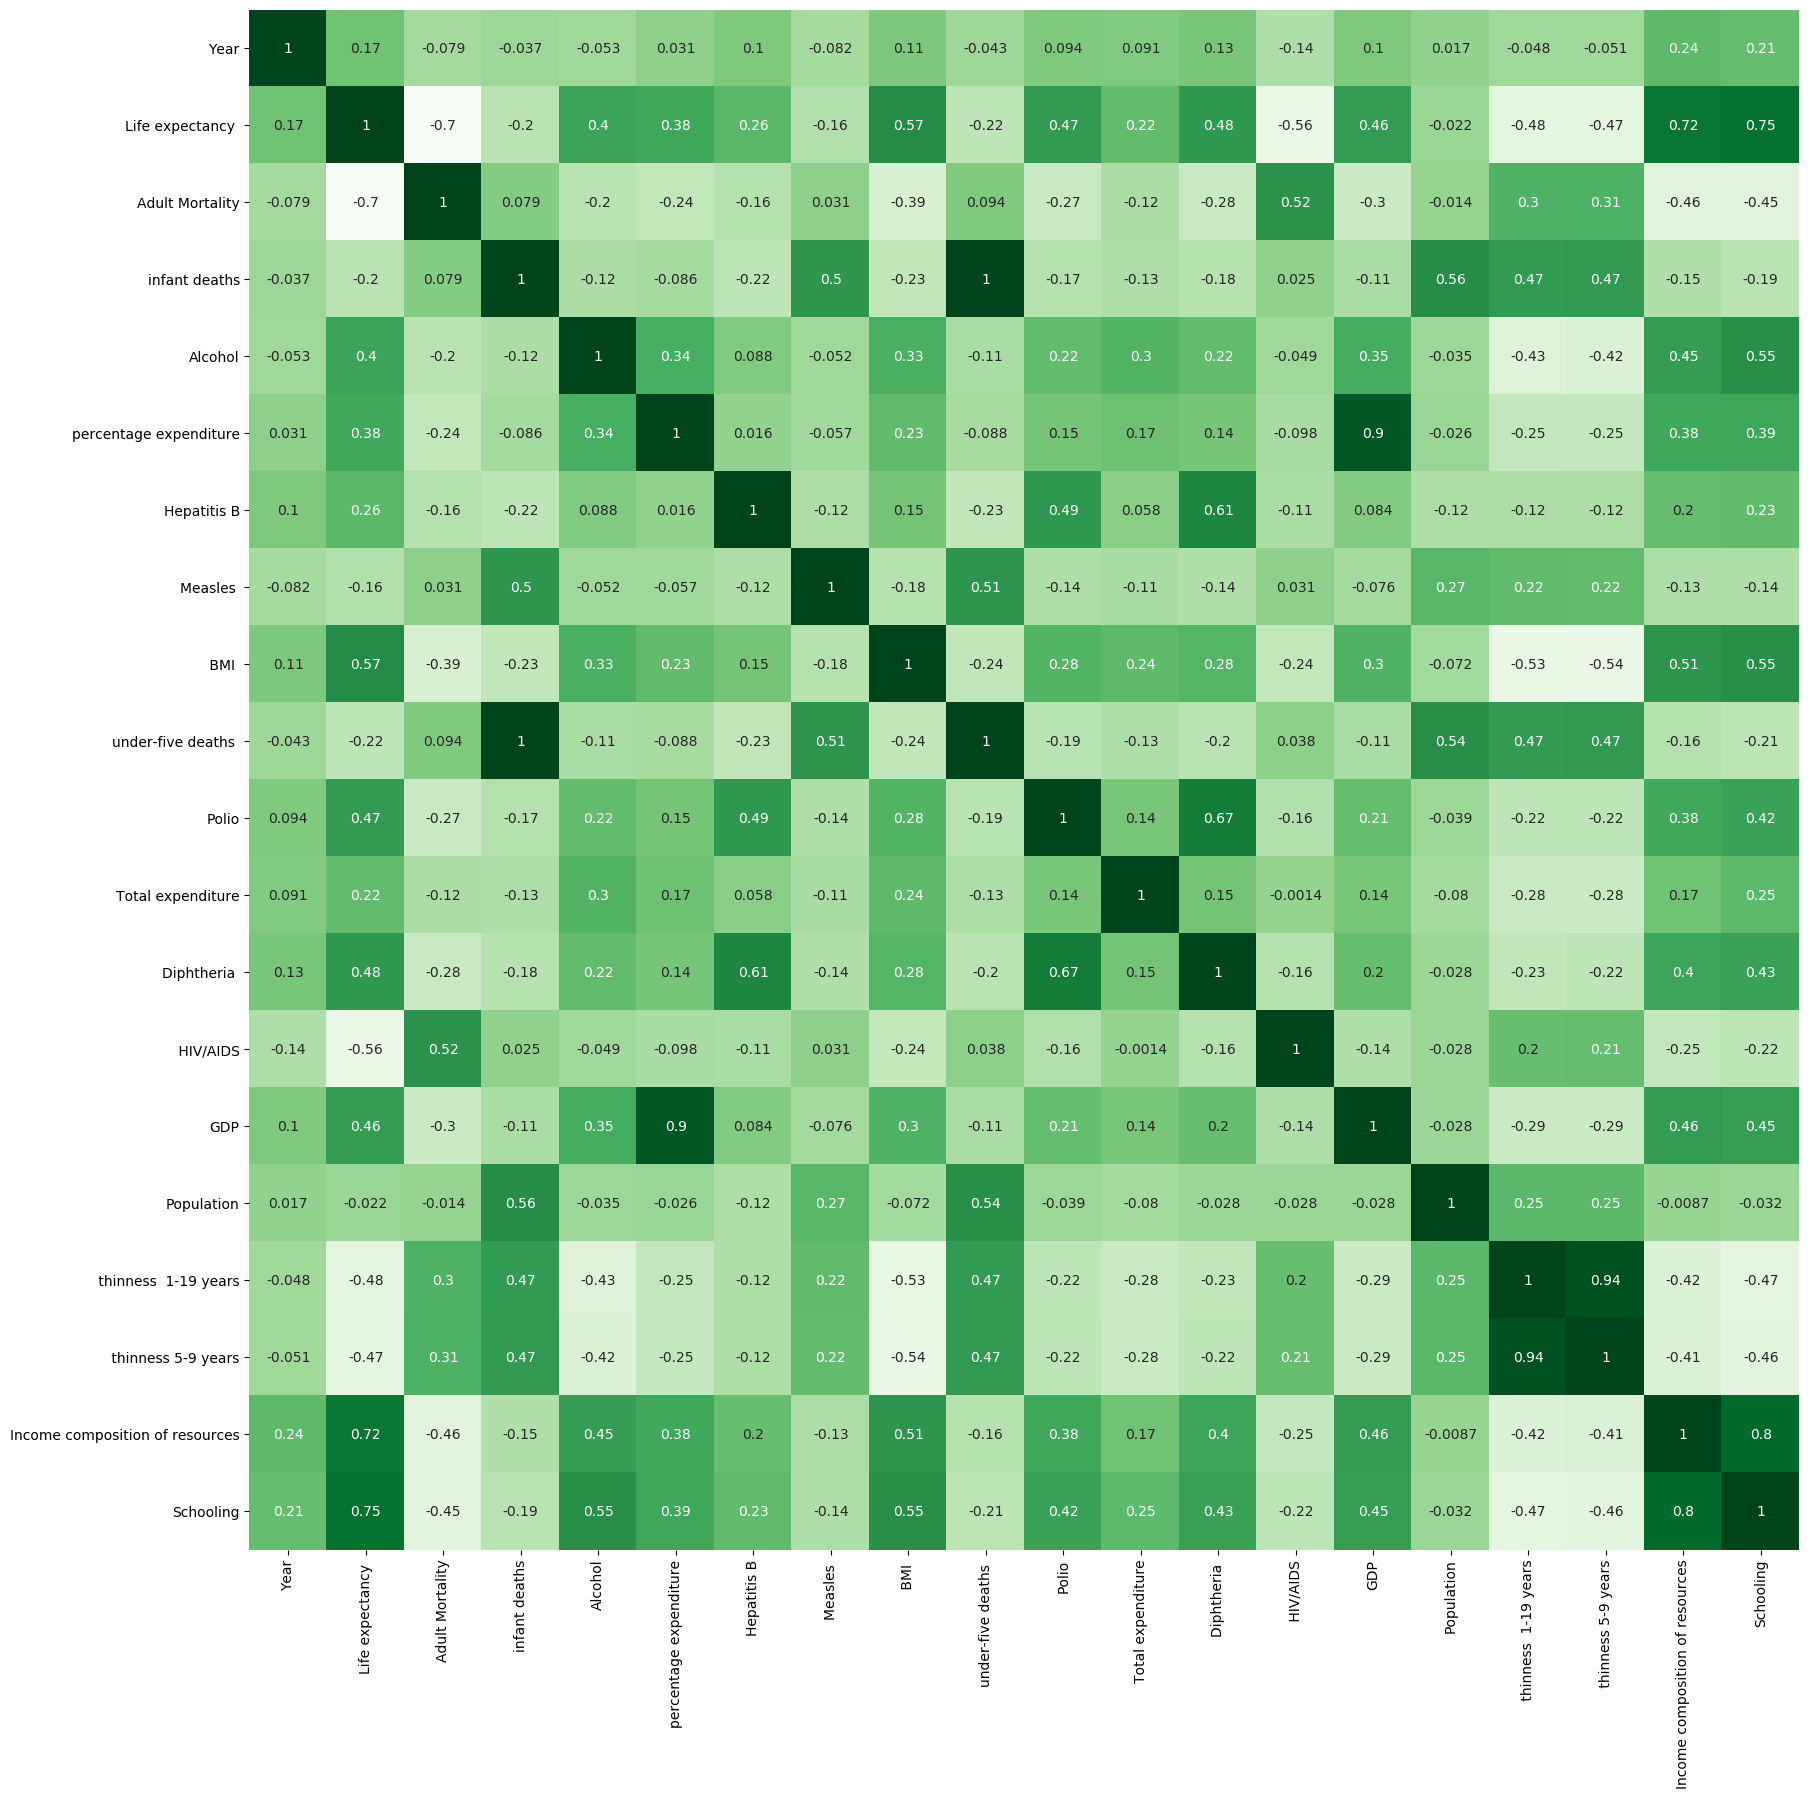

In [12]:
plt.figure(figsize = (20,20))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot = True,cmap='Greens',cbar=False)
plt.show()

## Dealing with missing and categorcal data

In [13]:
data = pd.get_dummies(data, columns = ['Status'])
data

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developed,Status_Developing
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,0,1
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,0,1
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,0,1
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,0,1
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,42,...,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2,0,1
2934,2003,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,41,...,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5,0,1
2935,2002,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,40,...,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0,0,1
2936,2001,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,39,...,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8,0,1


In [14]:
data.isnull().sum()

Year                                 0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
Status_Developed                     0
Status_Developing                    0
dtype: int64

In [15]:
data = data.apply(lambda x: x.fillna(x.mean()),axis=0)

In [16]:
data.isnull().sum()

Year                               0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Status_Developed                   0
Status_Developing                  0
dtype: int64

## Preparing data, train, val, test data:

In [17]:
X = data.drop(columns='Life expectancy ')
X

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developed,Status_Developing
0,2015,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,0,1
1,2014,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,...,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,0,1
2,2013,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,...,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,0,1
3,2012,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,...,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,0,1
4,2011,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,...,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,723.0,27,4.36,0.000000,68.0,31,27.1,42,67.0,...,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2,0,1
2934,2003,715.0,26,4.06,0.000000,7.0,998,26.7,41,7.0,...,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5,0,1
2935,2002,73.0,25,4.43,0.000000,73.0,304,26.3,40,73.0,...,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0,0,1
2936,2001,686.0,25,1.72,0.000000,76.0,529,25.9,39,76.0,...,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8,0,1


In [18]:
y = data['Life expectancy ']
y

0       65.0
1       59.9
2       59.9
3       59.5
4       59.2
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: Life expectancy , Length: 2938, dtype: float64

In [19]:
X = X.to_numpy().astype('float32')

In [20]:
X

array([[2.015e+03, 2.630e+02, 6.200e+01, ..., 1.010e+01, 0.000e+00,
        1.000e+00],
       [2.014e+03, 2.710e+02, 6.400e+01, ..., 1.000e+01, 0.000e+00,
        1.000e+00],
       [2.013e+03, 2.680e+02, 6.600e+01, ..., 9.900e+00, 0.000e+00,
        1.000e+00],
       ...,
       [2.002e+03, 7.300e+01, 2.500e+01, ..., 1.000e+01, 0.000e+00,
        1.000e+00],
       [2.001e+03, 6.860e+02, 2.500e+01, ..., 9.800e+00, 0.000e+00,
        1.000e+00],
       [2.000e+03, 6.650e+02, 2.400e+01, ..., 9.800e+00, 0.000e+00,
        1.000e+00]], dtype=float32)

In [21]:
y = y.to_numpy().astype('float32')

In [22]:
y

array([65. , 59.9, 59.9, ..., 44.8, 45.3, 46. ], dtype=float32)

In [23]:
X.shape, y.shape

((2938, 21), (2938,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [25]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=5)

In [26]:
X_train.shape, X_test.shape, X_val.shape

((2350, 21), (294, 21), (294, 21))

## Linear Learner in AWS SageMaker:

### Preparing data:

In [27]:
sagemaker_session = sagemaker.Session()

bucket = 'lifeexp'
folder = 'linear_learner' 

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::670725875030:role/service-role/AmazonSageMaker-ExecutionRole-20221025T025895


In [28]:
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_train, y_train)
buffer.seek(0)

key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(folder, 'train', key)).upload_fileobj(buffer)

s3_train_data = f's3://{bucket}/{folder}/train/{key}'
print(f'uploaded training data location: {s3_train_data}')

uploaded training data location: s3://lifeexp/linear_learner/train/linear-train-data


In [29]:
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_val, y_val)
buffer.seek(0)

key = 'linear-validation-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(folder, 'validation', key)).upload_fileobj(buffer)

s3_validation_data = f's3://{bucket}/{folder}/validation/{key}'
print(f'uploaded validation data location: {s3_validation_data}')

uploaded validation data location: s3://lifeexp/linear_learner/validation/linear-validation-data


In [30]:
output_folder = f's3://{bucket}/{folder}/output'
print(f'training artifacts will be uploaded to: {output_folder}')

training artifacts will be uploaded to: s3://lifeexp/linear_learner/output


In [31]:
boto3.Session().region_name

'us-west-2'

### Creating & training Linear Learner model:

In [32]:
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [33]:
linear_model = sagemaker.estimator.Estimator(container, 
                                             role, 
                                             instance_count = 1, 
                                             instance_type = 'ml.m4.xlarge',
                                             output_path = output_folder,
                                             sagemaker_session = sagemaker_session,
                                             use_spot_instances = True,
                                             max_run = 300,
                                             max_wait = 600)     

linear_model.set_hyperparameters(feature_dim = 21,
                                   predictor_type = 'regressor',
                                   mini_batch_size = 16,
                                   epochs = 100,
                                   num_models = 8,
                                   loss = 'absolute_loss')

In [34]:
linear_model.fit({'train': s3_train_data,'validation': s3_validation_data})

2022-12-22 10:13:44 Starting - Starting the training job...ProfilerReport-1671704024: InProgress
...
2022-12-22 10:14:27 Starting - Preparing the instances for training...............
2022-12-22 10:17:08 Downloading - Downloading input data.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/22/2022 10:17:55 INFO 140139070707520] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01', 'huber_delta': '1.0', 'num_class

### Deploy the Linear Learner model to endpoint:

In [35]:
linear_predictor = linear_model.deploy(initial_instance_count = 1, 
                                instance_type = "ml.m4.xlarge",
                                serializer=CSVSerializer(),
                                deserializer=JSONDeserializer())

---------!

In [36]:
linear_predictor.endpoint_name

'linear-learner-2022-12-22-10-18-59-589'

In [37]:
result = linear_predictor.predict(X_test)

{'predictions': [{'score': 75.63404083251953},
  {'score': 73.00228881835938},
  {'score': 74.43925476074219},
  {'score': 73.88919067382812},
  {'score': 69.57945251464844},
  {'score': 69.51423645019531},
  {'score': 77.0147705078125},
  {'score': 55.27037048339844},
  {'score': 70.30058288574219},
  {'score': 74.38591003417969},
  {'score': 50.16571807861328},
  {'score': 74.18268585205078},
  {'score': 69.54640197753906},
  {'score': 77.01775360107422},
  {'score': 60.2459831237793},
  {'score': 46.380706787109375},
  {'score': 78.06414794921875},
  {'score': 74.07176971435547},
  {'score': 53.713348388671875},
  {'score': 74.91938781738281},
  {'score': 72.19512939453125},
  {'score': 69.14107513427734},
  {'score': 71.20814514160156},
  {'score': 69.77981567382812},
  {'score': 62.9224967956543},
  {'score': 74.18603515625},
  {'score': 71.1202392578125},
  {'score': 72.24696350097656},
  {'score': 72.9947509765625},
  {'score': 63.145164489746094},
  {'score': 53.80584716796875}

In [38]:
y_pred = np.array([r['score'] for r in result['predictions']])
y_pred

array([75.63404083, 73.00228882, 74.43925476, 73.88919067, 69.57945251,
       69.51423645, 77.01477051, 55.27037048, 70.30058289, 74.38591003,
       50.16571808, 74.18268585, 69.54640198, 77.0177536 , 60.24598312,
       46.38070679, 78.06414795, 74.07176971, 53.71334839, 74.91938782,
       72.19512939, 69.14107513, 71.20814514, 69.77981567, 62.9224968 ,
       74.18603516, 71.12023926, 72.2469635 , 72.99475098, 63.14516449,
       53.80584717, 72.93293762, 82.60218811, 49.92496872, 70.4903183 ,
       64.23267365, 49.59677124, 62.03238297, 72.50319672, 51.26049805,
       56.77906799, 69.16511536, 69.50878906, 79.40655518, 62.3792572 ,
       72.27642059, 78.87224579, 73.05198669, 69.39189148, 59.86332703,
       50.71549988, 73.3157196 , 57.34812927, 68.91388702, 79.54795837,
       67.85412598, 73.99063873, 64.44557953, 61.04652023, 77.96784973,
       72.87480927, 75.85395813, 69.57531738, 73.05528259, 70.41213226,
       60.77796555, 75.79597473, 78.07328033, 82.90702057, 72.22

### Linear Learner model evaluation:

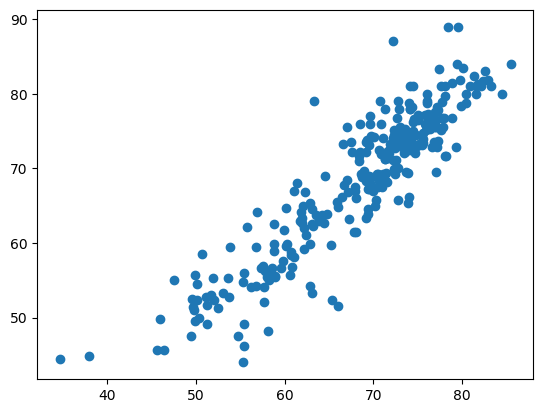

In [ ]:
plt.scatter(y_pred, y_test)
plt.show()

In [40]:
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 3.948 
MSE = 15.583639372341768 
MAE = 2.8600172834331485 
R2 = 0.8298110675192237 
Adjusted R2 = 0.8166714808203402


### Delete endpoint:

In [43]:
linear_predictor.delete_endpoint()

## XG-Boost in AWS SageMaker:

### Preparing data:

In [85]:
train_data = pd.DataFrame({'Target': y_train.reshape(-1,1)[:,0]})
for i in range(X_train.shape[1]):
    train_data[i] = X_train[:,i]

In [86]:
val_data = pd.DataFrame({'Target': y_val.reshape(-1,1)[:,0]})
for i in range(X_val.shape[1]):
    val_data[i] = X_val[:,i]

In [87]:
train_data.to_csv('train.csv', header = False, index = False)
val_data.to_csv('validation.csv', header = False, index = False)

In [88]:
sagemaker_session = sagemaker.Session()

bucket = 'lifeexp'
prefix = 'XG-Boost' 

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::670725875030:role/service-role/AmazonSageMaker-ExecutionRole-20221025T025895


In [89]:
key = 'xgboost-train-data'

with open('train.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

s3_train_data = f's3://{bucket}/{prefix}/train/{key}'
print(f'uploaded training data location: {s3_train_data}')

uploaded training data location: s3://lifeexp/XG-Boost/train/xgboost-train-data


In [90]:
key = 'xgboost-validation-data'
with open('train.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(f)

s3_validation_data = f's3://{bucket}/{prefix}/validation/{key}'
print(f'uploaded validation data location: {s3_validation_data}')

uploaded validation data location: s3://lifeexp/XG-Boost/validation/xgboost-validation-data


In [91]:
output_folder = f's3://{bucket}/{folder}/output'
print(f'training artifacts will be uploaded to: {output_folder}')

training artifacts will be uploaded to: s3://lifeexp/XG-Boost/output


In [92]:
boto3.Session().region_name

'us-west-2'

### Creating and Training XGBoost model:

In [93]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version='1.5-1')

In [94]:
xgboost_model = sagemaker.estimator.Estimator(container, 
                                             role, 
                                             instance_count = 1, 
                                             instance_type = 'ml.m4.xlarge',
                                             output_path = output_folder,
                                             sagemaker_session = sagemaker_session,
                                             use_spot_instances = True,
                                             max_run = 300,
                                             max_wait = 600)     

xgboost_model.set_hyperparameters(max_depth = 6,
                                    num_round = 100,
                                    alpha = 1,
                                    eta = 0.1,
                                    objective = 'reg:squarederror'                                  
                                   )

In [98]:
train_input = sagemaker.session.TrainingInput(s3_data = s3_train_data, content_type = 'csv', s3_data_type = 'S3Prefix')
valid_input = sagemaker.session.TrainingInput(s3_data = s3_validation_data, content_type = 'csv', s3_data_type = 'S3Prefix')


data_channels = {'train': train_input,'validation': valid_input}

In [99]:
xgboost_model.fit(data_channels)

2022-12-22 14:26:50 Starting - Starting the training job...
2022-12-22 14:27:16 Starting - Preparing the instances for trainingProfilerReport-1671719210: InProgress
............
2022-12-22 14:29:15 Downloading - Downloading input data...
2022-12-22 14:29:50 Training - Training image download completed. Training in progress....
2022-12-22 14:30:21 Uploading - Uploading generated training model
2022-12-22 14:30:21 Completed - Training job completed
[2022-12-22 14:30:05.870 ip-10-0-163-5.us-west-2.compute.internal:6 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-22:14:30:05:INFO] Imported framework sagemaker_xgboost_container.training
[2022-12-22:14:30:05:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2022-12-22:14:30:05:INFO] No GPUs detected (normal if no gpus installed)
[2022-12-22:14:30:05:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-12-22:14:30:05:INFO] Determined delimiter of CSV input is ','
[202

### Deploy XGBoost model to endpoint:

In [100]:
xgboost_predictor = xgboost_model.deploy(initial_instance_count = 1, 
                                instance_type = "ml.m4.xlarge",
                                serializer=CSVSerializer(),
                                deserializer=JSONDeserializer())

-------!

In [101]:
xgboost_predictor.endpoint_name

'sagemaker-xgboost-2022-12-22-14-32-41-340'

In [102]:
result = xgboost_predictor.predict(X_test)

In [103]:
y_pred = np.array([r['score'] for r in result['predictions']])
y_pred

array([74.80414581, 73.704422  , 74.70217896, 68.56077576, 70.6348114 ,
       72.94965363, 77.35015869, 56.15950012, 66.04924011, 74.14416504,
       53.51501846, 72.21282959, 69.38787842, 70.21572113, 59.22161484,
       46.81478882, 72.12785339, 66.87745667, 53.15909958, 70.84468842,
       71.42884064, 73.70265198, 73.04367065, 69.16603088, 64.46331787,
       72.70278931, 73.57868958, 72.23818207, 74.16574097, 63.58675003,
       59.56997299, 75.3895874 , 81.60492706, 54.50741577, 70.02257538,
       64.53356934, 53.76007843, 62.47622681, 72.99097443, 52.08556366,
       60.50949097, 71.25518036, 68.37850189, 81.74211884, 62.12995529,
       73.32154846, 76.07482147, 70.25180054, 68.49065399, 57.22882462,
       56.94627762, 73.73542786, 55.70669556, 69.67279053, 84.17411041,
       64.42921448, 73.61976624, 61.61941528, 67.26782227, 75.64807129,
       72.26938629, 75.63956451, 71.30730438, 74.94749451, 69.34307861,
       60.19337845, 76.99684906, 80.66884613, 82.34965515, 73.19

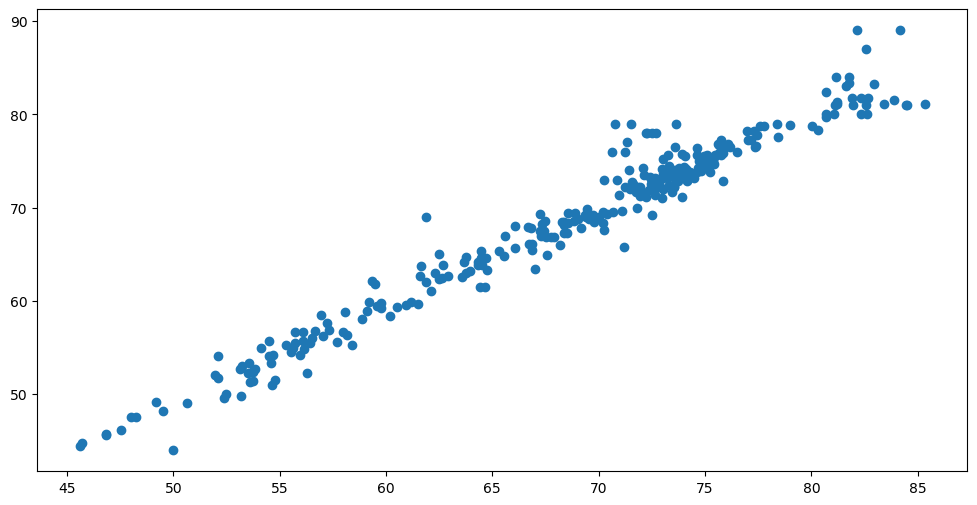

In [104]:
plt.scatter(y_pred, y_test)
plt.show()

In [105]:
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 1.914 
MSE = 3.6650951101461393 
MAE = 1.2948191247018828 
R2 = 0.9599734946803667 
Adjusted R2 = 0.9568832130196597


### Delete endpoint:

In [106]:
xgboost_predictor.delete_endpoint()